<a href="https://colab.research.google.com/github/DeepakGoli/Anamoly-Detection/blob/master/ENet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import keras
import cv2

class DataGenerator(keras.utils.Sequence):
    'Generates batches of data for a system'
    
    def __init__(self,list_IDs,path_to_dir,batch_size=4,dim=(256,400,1),shuffle=True):
        self.list_IDs  = list_IDs
        self.batch_size= batch_size
        self.dim       = dim
        self.shuffle   = shuffle
        self.path_to_dir = path_to_dir
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'updates indexes after each epoch. Shuffling of our dataset happens here'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Gives number of batches per epoch'
        return int(np.floor(len(self.list_IDs)/self.batch_size))
    
    def __data_generation(self,list_IDs_temp):
        'Generates data containing batch_size samples'
        #initialization
        #X=np.empty((self.batch_size,*self.dim,self.n_channels))
        X=np.empty((self.batch_size,*self.dim))
        y=np.empty((self.batch_size,*self.dim),dtype=int)
        
        #Generate data
        for i,ID in enumerate(list_IDs_temp):
            #store sample
            #X[i,] = np.load('data'+ID+'.npy')
            temp_x = cv2.imread(self.path_to_dir+'/original_100/'+ID,0)/255
            resize_x = cv2.resize(temp_x,(384,256))
            X[i,:,:,0]=resize_x
            #X[i,:,:,0]
            #X[i,:,:,0] = cv2.imread(self.path_to_dir+'/original_100/'+ID,0)/255
            #sotre class
            temp_y = self.__data_augmentation(ID)
            resize_y = cv2.resize(temp_y,(384,256))
            y[i,:,:,0] = resize_y
            #y[i,:,:,0] = self.__data_augmentation(ID)
        return X, y
    
    def __getitem__(self,index):
        'Generate one batch of data'
        #Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        #find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        #Generate data
        X,y = self.__data_generation(list_IDs_temp)
        return X,y
    
    def __data_augmentation(self,ID_temp):
        #Generates (256,400,1) dimensional mask
        y=cv2.imread(self.path_to_dir+'/mask_100/'+ID_temp,0)/255
        y[y>0.5]=1
        y[y<=0.5]=0
        return y

        

In [0]:
import os
import sys
import numpy
def visualize_items(**items):
  'function used to visualize the output of __getitem__() of the data generator'
  n=len(items)
  for idx,a in enumerate(arrays.items()):
    dim = a[0].shape
    numpy.set_printoptions(threshold=sys.maxsize)
    print(dim)
path_to_database='/content/drive/My Drive/AnamolyDetection/new_100'
IDs=os.listdir(path_to_database+'/mask_100/')
IDs_train = IDs[:int(np.floor(0.9*len(IDs)))]
IDs_val = IDs[int(np.floor(0.9*len(IDs))):]
train_gen=DataGenerator(IDs_train,path_to_database,batch_size=4,dim=(256,384,1))
val_gen = DataGenerator(IDs_val,path_to_database,batch_size=4,dim=(256,384,1))
x=train_gen.__getitem__(0)
print(np.shape(x))
#numpy.set_printoptions(threshold=sys.maxsize)
#print(train_gen.__getitem__(2))

(2, 4, 256, 384, 1)


In [0]:

import keras.backend as k
def custom_loss(y_true,y_pred):
    #custom loss function
    w_defect = 0.8
    w_background = 0.2
    smooth = 1e-8
    y_t=k.flatten(y_true)
    y_p=k.flatten(y_pred)
    return -k.mean(w_defect*y_t*k.log(y_p+smooth)+w_background*(1-y_t)*k.log(1-y_p+smooth))
def weighted_exp_loss(y_true,y_pred):
  w_defect = 0.8
  w_background = 0.2
  smooth = 1e-8
  y_true = k.flatten(y_true)
  y_pred = k.flatten(y_pred)
  y_error = y_true-y_pred
  error_r = 1
  abs_error = k.abs(y_true-y_pred)
  exp_error = k.exp(abs_error+error_r)-np.exp(error_r)
  return k.mean(w_defect*y_true*exp_error+w_background*(1-y_true)*exp_error)
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = k.flatten(y_true)
    y_pred_f = k.flatten(y_pred)
    intersection = k.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (k.sum(y_true_f) + k.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
def mfm(x):
    shape = k.int_shape(x)
    x  = Permute(dims=(3,2,1))(x) #swapping 1st and 3rd axis
    x1 = Cropping2D(cropping=((0,shape[3]//2),0))(x) 
    x2 = Cropping2D(cropping=((shape[3]//2,0),0))(x)
    x = Maximum()([x1 , x2])
    x = Permute(dims=(3,2,1))(x) #swapping 1st and 3rd axis
    x = Reshape([shape[1],shape[2],shape[3]//2])(x)
    return x
    

In [0]:
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Conv2D, ZeroPadding2D
from keras.layers.core import SpatialDropout2D, Permute
from keras.layers.merge import add, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D


def initial_block(inp, nb_filter=13, nb_row=3, nb_col=3, strides=(2, 2)):
    conv = Conv2D(nb_filter, (nb_row, nb_col), padding='same', strides=strides)(inp)
    max_pool = MaxPooling2D()(inp)
    merged = concatenate([conv, max_pool], axis=3)
    return merged


def bottleneck_encoder(inp, output, internal_scale=4, asymmetric=0, dilated=0, downsample=False, dropout_rate=0.1):
    # main branch
    internal = int(output / internal_scale)
    encoder = inp

    # 1x1
    input_stride = 2 if downsample else 1  # the 1st 1x1 projection is replaced with a 2x2 convolution when downsampling
    encoder = Conv2D(internal, (input_stride, input_stride),
                            # padding='same',
                            strides=(input_stride, input_stride), use_bias=False)(encoder)
    # Batch normalization + PReLU
    encoder = BatchNormalization(momentum=0.1)(encoder)  # enet uses momentum of 0.1, keras default is 0.99
    encoder = PReLU(shared_axes=[1, 2])(encoder)

    # conv
    if not asymmetric and not dilated:
        encoder = Conv2D(internal, (3, 3), padding='same')(encoder)
    elif asymmetric:
        encoder = Conv2D(internal, (1, asymmetric), padding='same', use_bias=False)(encoder)
        encoder = Conv2D(internal, (asymmetric, 1), padding='same')(encoder)
    elif dilated:
        encoder = Conv2D(internal, (3, 3), dilation_rate=(dilated, dilated), padding='same')(encoder)
    else:
        raise(Exception('You shouldn\'t be here'))

    encoder = BatchNormalization(momentum=0.1)(encoder)  # enet uses momentum of 0.1, keras default is 0.99
    encoder = PReLU(shared_axes=[1, 2])(encoder)
    
    # 1x1
    encoder = Conv2D(output, (1, 1), use_bias=False)(encoder)

    encoder = BatchNormalization(momentum=0.1)(encoder)  # enet uses momentum of 0.1, keras default is 0.99
    encoder = SpatialDropout2D(dropout_rate)(encoder)

    other = inp
    # other branch
    if downsample:
        other = MaxPooling2D()(other)

        other = Permute((1, 3, 2))(other)
        pad_feature_maps = output - inp.get_shape().as_list()[3]
        tb_pad = (0, 0)
        lr_pad = (0, pad_feature_maps)
        other = ZeroPadding2D(padding=(tb_pad, lr_pad))(other)
        other = Permute((1, 3, 2))(other)

    encoder = add([encoder, other])
    encoder = PReLU(shared_axes=[1, 2])(encoder)
    return encoder


def ENet_encoder(inp, dropout_rate=0.01):
    enet = initial_block(inp)
    enet = bottleneck_encoder(enet, 64, downsample=True, dropout_rate=dropout_rate)  # bottleneck 1.0
    for i in range(4):
        enet = bottleneck_encoder(enet, 64, dropout_rate=dropout_rate)  # bottleneck 1.i
    
    enet = bottleneck_encoder(enet, 128, downsample=True)  # bottleneck 2.0
    # bottleneck 2.x and 3.x
    for i in range(2):
        enet = bottleneck_encoder(enet, 128)  # bottleneck 2.1
        enet = bottleneck_encoder(enet, 128, dilated=2)  # bottleneck 2.2
        enet = bottleneck_encoder(enet, 128, asymmetric=5)  # bottleneck 2.3
        enet = bottleneck_encoder(enet, 128, dilated=4)  # bottleneck 2.4
        enet = bottleneck_encoder(enet, 128)  # bottleneck 2.5
        enet = bottleneck_encoder(enet, 128, dilated=8)  # bottleneck 2.6
        enet = bottleneck_encoder(enet, 128, asymmetric=5)  # bottleneck 2.7
        enet = bottleneck_encoder(enet, 128, dilated=16)  # bottleneck 2.8
    return enet

In [0]:
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.core import Activation
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization


def bottleneck_decoder(encoder, output, upsample=False, reverse_module=False):
    internal = int(output / 4)

    x = Conv2D(internal, (1, 1), use_bias=False)(encoder)
    x = BatchNormalization(momentum=0.1)(x)
    x = Activation('relu')(x)
    if not upsample:
        x = Conv2D(internal, (3, 3), padding='same', use_bias=True)(x)
    else:
        x = Conv2DTranspose(filters=internal, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization(momentum=0.1)(x)
    x = Activation('relu')(x)

    x = Conv2D(output, (1, 1), padding='same', use_bias=False)(x)

    other = encoder
    if encoder.get_shape()[-1] != output or upsample:
        other = Conv2D(output, (1, 1), padding='same', use_bias=False)(other)
        other = BatchNormalization(momentum=0.1)(other)
        if upsample and reverse_module:
            other = UpSampling2D(size=(2, 2))(other)
        
    if not upsample or reverse_module:
        x = BatchNormalization(momentum=0.1)(x)
    else:
        return x
    
    decoder = add([x, other])
    decoder = Activation('relu')(decoder)
    return decoder


def ENet_decoder(encoder, nc):
    enet = bottleneck_decoder(encoder, 64, upsample=True, reverse_module=True)  # bottleneck 4.0
    enet = bottleneck_decoder(enet, 64)  # bottleneck 4.1
    enet = bottleneck_decoder(enet, 64)  # bottleneck 4.2
    enet = bottleneck_decoder(enet, 16, upsample=True, reverse_module=True)  # bottleneck 5.0
    enet = bottleneck_decoder(enet, 16)  # bottleneck 5.1

    enet = Conv2DTranspose(filters=nc, kernel_size=(2, 2), strides=(2, 2), padding='same')(enet)
    return enet

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 384, 1)  0                                            
__________________________________________________________________________________________________
conv2d_345 (Conv2D)             (None, 128, 192, 13) 130         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 128, 192, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 128, 192, 14) 0           conv2d_345[0][0]                 
                                                                 max_pooling2d_13[0][0]     

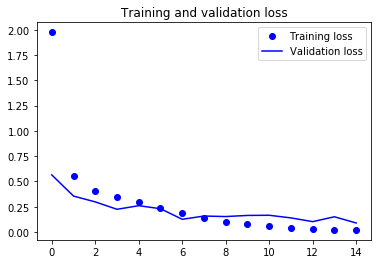

NameError: ignored

In [0]:
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Conv2D, ZeroPadding2D
from keras.layers.core import SpatialDropout2D, Permute
from keras.layers.merge import add, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt  
input_image = Input(shape=(256,384,1))

def ENet(input_image):
  encoder = ENet_encoder(input_image)
  decoder = ENet_decoder(encoder,nc=1)
  return decoder

encoder_model = Model(input_image, ENet(input_image))
encoder_model.compile(optimizer = Adam(lr = 1e-4), loss = weighted_exp_loss, metrics = [dice_coef])
#encoder_model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coeff_loss, metrics = [dice_coef])
encoder_model.summary()
epochs=15
autoencoder_train = encoder_model.fit_generator(train_gen,epochs=epochs,steps_per_epoch=2000,validation_data=val_gen)
train_loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs,train_loss,'bo', label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

i = val_gen.__getitem__(1)
x_i = i[0]
m_i = i[1]
output_1 = encoder_model.predict(x_i)
fig1 = plt.figure()
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.tight_layout()
  plt.imshow(x_i[i,:,:,0], cmap='gray', interpolation='none')
  plt.title("Input Image")
  plt.xticks([])
  plt.yticks([])
fig2 = plt.figure()
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.tight_layout()
  plt.imshow(m_i[i,:,:,0], cmap='gray', interpolation='none')
  plt.title("Mask Image")
  plt.xticks([])
  plt.yticks([])
fig3 = plt.figure()
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.tight_layout()
  plt.imshow(output_1[i,:,:,0], cmap='gray', interpolation='none')
  plt.title("Prediction Mask")
  plt.xticks([])
  plt.yticks([])

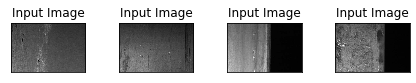

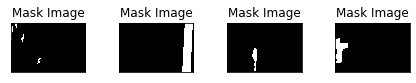

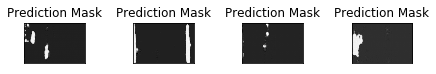

In [0]:

i = val_gen.__getitem__(1)
x_i = i[0]
m_i = i[1]
output_1 = encoder_model.predict(x_i)
fig1 = plt.figure()
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.tight_layout()
  plt.imshow(x_i[i,:,:,0], cmap='gray', interpolation='none')
  plt.title("Input Image")
  plt.xticks([])
  plt.yticks([])
fig2 = plt.figure()
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.tight_layout()
  plt.imshow(m_i[i,:,:,0], cmap='gray', interpolation='none')
  plt.title("Mask Image")
  plt.xticks([])
  plt.yticks([])
fig3 = plt.figure()
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.tight_layout()
  plt.imshow(output_1[i,:,:,0], cmap='gray', interpolation='none')
  plt.title("Prediction Mask")
  plt.xticks([])
  plt.yticks([])
